# Support vector classifier: spam detection

In [1]:
# Python standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk import download as nltk_download
from scipy.stats import randint, uniform, loguniform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import helper_functions as funcs

nltk_download('stopwords')

RANDOM_SEED = 315
CLASS_WEIGHT = 'balanced'
N_SPLITS = 3

CV = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_SEED
)

# Hyperparameter search settings
N_JOBS = 1
N_ITER = 10000

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data loading

### 1.1. Load data from URL

In [2]:
# Read csv file into dataframe
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Save a local copy

In [3]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/urls.parquet')

### 1.3. Inspect the data

In [4]:
data_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.0+ KB


## 2. EDA

### 2.1. Label frequency

In [6]:
label_counts = data_df['is_spam'].value_counts()

not_spam = label_counts.iloc[0]
spam = label_counts.iloc[1]

print(f'URLs are {(not_spam/(spam + not_spam)*100):.1f}% not spam')

URLs are 89.7% not spam


### 2.2. URL length distribution

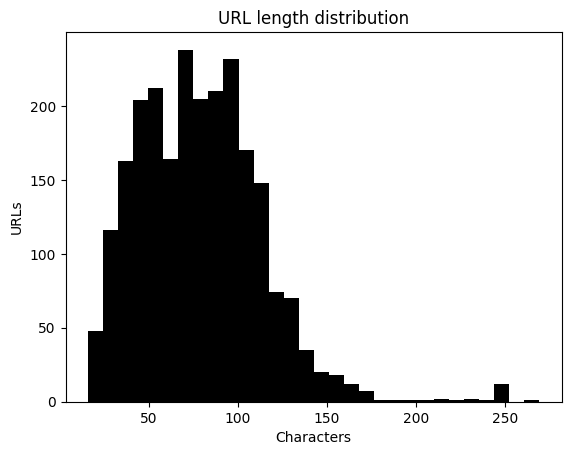

URL length mean: 79
URL length min: 16
URL length max: 269


In [7]:
data_df['URL_length'] = data_df['url'].str.len().tolist()

plt.title('URL length distribution')
plt.xlabel('Characters')
plt.ylabel('URLs')
plt.hist(data_df['URL_length'], bins=30, color='black')
plt.show()

print(f"URL length mean: {np.mean(data_df['URL_length']):.0f}")
print(f"URL length min: {min(data_df['URL_length']):.0f}")
print(f"URL length max: {max(data_df['URL_length']):.0f}")

### 2.3. Short URLs

In [8]:
short_urls = data_df[data_df['URL_length'] < 20]
short_urls

,url,is_spam,URL_length
150,https://neeva.co/,False,17
656,https://qz.com/app/,False,19
676,https://digg.com/,True,17
728,https://uqora.com/,True,18
963,https://tim.blog/,True,17
971,http://abw.blue/,False,16
978,https://mowned.com/,False,19
995,https://waxy.org/,True,17
1158,https://hey.com/,True,16
1469,https://woven.com/,False,18


### 2.4. Long URLs

In [9]:
long_urls = data_df[data_df['URL_length'] > 200]
long_urls

,url,is_spam,URL_length
472,https://www.youtube.com/watch?v=4An0ndagZsQ&fe...,False,244
479,https://www.youtube.com/watch?v=oieBnV_HFB0&fe...,False,244
480,https://www.youtube.com/watch?v=PQmDUEv939A&fe...,False,244
481,https://www.youtube.com/watch?v=QrGEIWe0JXY&fe...,False,244
587,https://www.youtube.com/watch?v=S0qrinhNnOM&fe...,False,244
663,https://www.youtube.com/watch?v=gbCREJh6aCc&fe...,False,244
914,https://www.npr.org/sections/live-updates-prot...,False,269
1285,https://www.youtube.com/watch?v=SrLZgP-OR6s&ut...,False,227
1286,https://www.youtube.com/watch?v=N13WI3oVda8&ut...,False,227
1290,https://www.youtube.com/watch?v=Yz3mQhuMACs&fe...,False,244


## 3. Data preprocessing

### 3.1. Label encoding

In [10]:
data_df['is_spam'] = data_df['is_spam'].astype(str)
data_df['is_spam'] = data_df['is_spam'].replace({'True': '1', 'False': '0'})
data_df['is_spam'] = data_df['is_spam'].astype(int)

### 3.2. Train test split

In [11]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=RANDOM_SEED)

### 3.3. URL vectorization

In [12]:
# Vectorize the URLs using TF-IDF
vectorizer = TfidfVectorizer()
train_urls = vectorizer.fit_transform(train_df['url'])
test_urls = vectorizer.transform(test_df['url'])

# Get the words from the vector model
feature_names = vectorizer.get_feature_names_out()

train_urls

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 19360 stored elements and shape (1658, 5357)>

In [13]:
feature_names

array(['0027', '003722', '01', ..., 'zuckerberg', 'zwift', 'zyguxzjc_cs'],
      shape=(5357,), dtype=object)

### 3.4. Mean TF-IDF value distribution

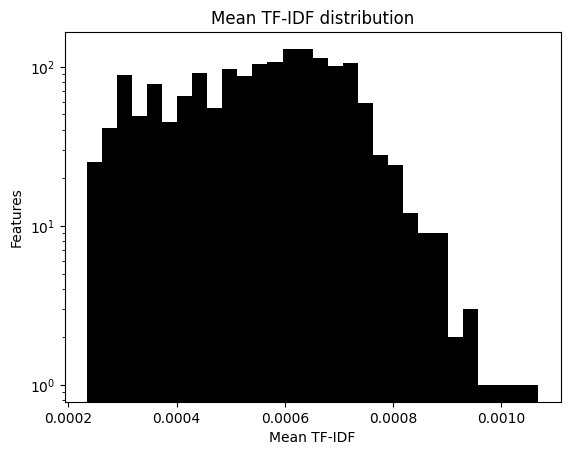

In [14]:
# Get the mean TF-IDF value for each feature
feature_means = np.mean(train_urls.toarray(), axis=1)

plt.title('Mean TF-IDF distribution')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Features')
plt.hist(feature_means, bins=30, color='black')
plt.yscale('log')
plt.show()

## 3. SVM model

### 3.1. Baseline model performance

In [15]:
# Instantiate the support vector machine classifier with defaults
naive_svc = SVC(class_weight=CLASS_WEIGHT, random_state=RANDOM_SEED)

# Cross-validate the default model on the encoded training data
scores = cross_val_score(
    naive_svc,
    train_urls,
    train_df['is_spam'],
    cv=CV,
    n_jobs=-1
)

# Save the baseline cross-validation scores for later
cross_val_scores = {
    'Model': ['Naive SVC']*N_SPLITS,
    'Score': list(scores)
}

print(f'Naive SVC cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Naive SVC cross validation accuracy: 93.4+/-1.1%


### 3.2. SVC hyperparameter optimization

In [16]:
# Set the hyperparameter search space
hyperparameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr']
}

# Instantiate a new model
model = SVC(class_weight=CLASS_WEIGHT, random_state=RANDOM_SEED)

# Set up the grid search
grid = GridSearchCV(model, hyperparameters, scoring='accuracy', cv=CV, n_jobs=N_JOBS)

# Run the search
optimization_results = grid.fit(train_urls, train_df['is_spam'])

# Recover winning model & hyperparameters
optimized_svc = grid.best_estimator_
best_hyperparameters = grid.best_params_

print(f'Best hyperparameters:\n')

for key, val in best_hyperparameters.items():
    print(f' {key}: {val}')

Best hyperparameters:

 C: 1
 decision_function_shape: ovo
 degree: 2
 gamma: scale
 kernel: linear
 shrinking: True


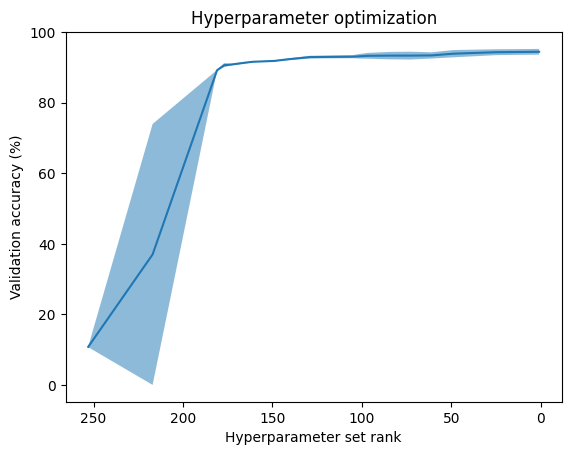

In [17]:
funcs.plot_cross_validation(optimization_results)

In [18]:
# Cross-validate the optimized model on the encoded training data
scores = cross_val_score(
    optimized_svc,
    train_urls,
    train_df['is_spam'],
    cv=CV,
    n_jobs=-1
)

# Save the optimized cross-validation scores for later
cross_val_scores['Model'].extend(['Optimized SVC']*N_SPLITS)
cross_val_scores['Score'].extend(scores)

print(f'Optimized SVC cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Optimized SVC cross validation accuracy: 94.5+/-0.8%


### 3.3. TFIDFVectorizer + SVC hyperparameter optimization

In [19]:
tfidf = TfidfVectorizer()
svc = SVC(class_weight=CLASS_WEIGHT, random_state=RANDOM_SEED)

# Create pipeline with PCA, scaling, and classifier
pipe = Pipeline(steps=[('TFIDF', tfidf), ('SVC', svc)])

hyperparameters = {
    'TFIDF__strip_accents': ['ascii', 'unicode', None],
    'TFIDF__stop_words': ['english', stopwords.words('english'), None],
    'TFIDF__ngram_range': [(1,1), (1,2), (2,2)],
    'TFIDF__max_df': uniform(loc=0.0009, scale=0.9991),
    'TFIDF__min_df': uniform(loc=0.0, scale=0.0004),
    'TFIDF__max_features': randint(1, len(feature_names)),
    'TFIDF__binary': [True, False],
    'TFIDF__norm': ['l1', 'l2', None],
    'TFIDF__use_idf': [True, False],
    'TFIDF__smooth_idf': [True, False],
    'TFIDF__sublinear_tf': [True, False],
    'SVC__C': loguniform(10**-2, 100.0),
    'SVC__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'SVC__degree': [1, 2, 3],
    'SVC__gamma': ['scale', 'auto'],
    'SVC__shrinking': [True, False],
    'SVC__decision_function_shape': ['ovo', 'ovr']
}

grid = RandomizedSearchCV(
    pipe,
    hyperparameters,
    return_train_score=True,     # Return training scores for analysis
    cv=CV,                       # Use stratified shuffle split for cross-validation
    n_jobs=N_JOBS,               # Use all available CPU cores
    n_iter=N_ITER,               # Number of parameter combinations to try
    random_state=RANDOM_SEED     # Ensure reproducible results
)

# Run the search
optimization_results = grid.fit(train_df['url'], train_df['is_spam'])

# Recover winning model & hyperparameters
optimized_tfidf_svc = grid.best_estimator_
best_hyperparameters = grid.best_params_

print(f'Best hyperparameters:\n')

for key, val in best_hyperparameters.items():
    print(f' {key}: {val}')

Best hyperparameters:

 SVC__C: 0.6785311939174228
 SVC__decision_function_shape: ovo
 SVC__degree: 2
 SVC__gamma: scale
 SVC__kernel: rbf
 SVC__shrinking: False
 TFIDF__binary: True
 TFIDF__max_df: 0.46558106827270646
 TFIDF__max_features: 2251
 TFIDF__min_df: 0.0003248123931395679
 TFIDF__ngram_range: (1, 1)
 TFIDF__norm: l1
 TFIDF__smooth_idf: True
 TFIDF__stop_words: english
 TFIDF__strip_accents: ascii
 TFIDF__sublinear_tf: False
 TFIDF__use_idf: False


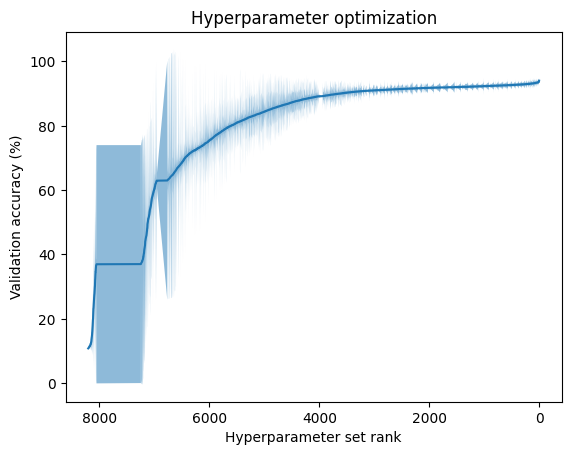

In [20]:
funcs.plot_cross_validation(optimization_results)

In [21]:
# Cross-validate the optimized model on the encoded training data
scores = cross_val_score(
    optimized_tfidf_svc,
    train_df['url'],
    train_df['is_spam'],
    cv=CV,
    n_jobs=-1
)

# Save the optimized cross-validation scores for later
cross_val_scores['Model'].extend(['Optimized TFIDF + SVC']*N_SPLITS)
cross_val_scores['Score'].extend(scores)

print(f'Optimized TFIDF + SVC cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Optimized TFIDF + SVC cross validation accuracy: 94.0+/-0.8%


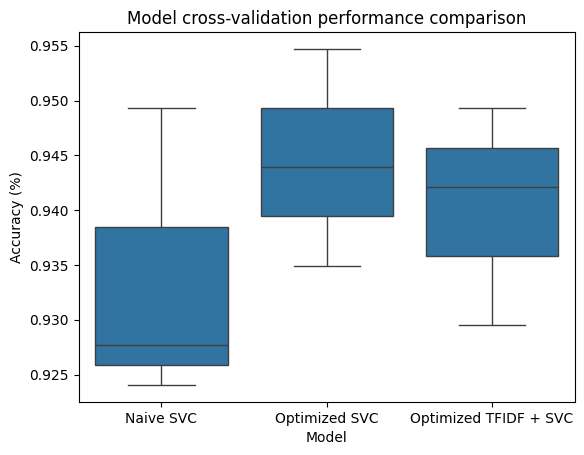

In [22]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

## 4. Model evaluation

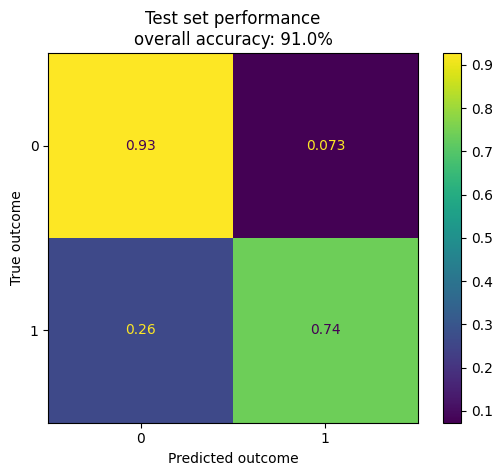

In [25]:
optimized_svc.fit(train_urls, train_df['is_spam'])
predictions = optimized_svc.predict(test_urls)

accuracy = accuracy_score(test_df['is_spam'], predictions)*100

# Plot the confusion matrix
cm = confusion_matrix(test_df['is_spam'], predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()